Here we present a simple example of how to use fine-tuning with the `sentence-transformers` library.

The example is similar to the one in the `transfer_learning.ipynb` notebook, but first we fine-tune the MLM objective to get better embeddings, and then we do the clustering.

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

from transformers import AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from datasets import Dataset
import torch

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Generate a toy dataset with two categories: pet and finance
pet_documents = [
    "I love playing with my dog in the park",
    "The cat sleeps peacefully on the windowsill",
    "My dog enjoys running in the garden",
    "Cats are very independent pets",
    "Taking my puppy for daily walks",
    "The kitten plays with yarn all day",
    "Dogs need regular exercise and training",
    "My cat purrs when I pet her",
    "Feeding time is my pet's favorite",
    "Playing fetch with pets is fun"
]

finance_documents = [
    "The stock market crashed today",
    "Bitcoin prices are very volatile",
    "Investors lost money in the downturn",
    "Bull market continues its upward trend",
    "Trading volume hits record high",
    "Cryptocurrency adoption is growing",
    "Market analysts predict recession",
    "Stock indices reach new peaks",
    "Investment strategies for beginners",
    "Financial markets remain uncertain"
]

# Create balanced dataset with 50 examples of each category
# Using random variations with noise words to create more diversity

def add_noise_to_text(text):
    noise_words = [
        "today", "yesterday", "recently", "definitely", "absolutely",
        "quite", "very", "extremely", "somewhat", "rather"
    ]
    words = text.split()
    # 50% chance to add a noise word at the start
    if random.random() > 0.5:
        words.insert(0, random.choice(noise_words))
    # 50% chance to add a noise word at the end
    if random.random() > 0.5:
        words.append(random.choice(noise_words))
    return " ".join(words)

documents = []
for _ in range(50):  # 50 examples of each category
    documents.append(add_noise_to_text(random.choice(pet_documents)))
    documents.append(add_noise_to_text(random.choice(finance_documents)))

# Shuffle the documents
random.shuffle(documents)

In [3]:
# Create dataset
dataset = Dataset.from_dict({"text": documents})

# Check available device (mps for mac, cuda for gpu)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# Initialize tokenizer and model
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name).to(device)

# Function to get embeddings from the model
def get_embeddings(texts):
    # Tokenize texts
    encoded = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    
    # Get model outputs
    with torch.no_grad():
        outputs = model(**encoded, output_hidden_states=True)
    
    # Use the last hidden state's [CLS] token as the sentence embedding
    embeddings = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
    return embeddings

# Define training arguments with specific device settings
training_args = TrainingArguments(
    output_dir="./mlm_model",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    save_steps=500,
    save_total_limit=2,
    prediction_loss_only=True,
    no_cuda=True if device.type == "mps" else False,  # Disable CUDA if using MPS
)

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Create data collator for MLM
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./mlm_model",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    save_steps=500,
    save_total_limit=2,
    prediction_loss_only=True,
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
)

# Train the model
print("Training model...")
trainer.train()

# Test the model
test_sentences = [
    "My new puppy loves to play fetch",
    "The market showed strong gains this quarter",
    "Cats enjoy sleeping in the sun",
    "Investors are worried about inflation"
]

# Get embeddings and calculate similarities
embeddings = get_embeddings(test_sentences)

# Calculate similarities
similarities = cosine_similarity(embeddings)

print("\nSimilarity matrix:")
for i, sent1 in enumerate(test_sentences):
    print(f"\nSimilarities for: '{sent1}'")
    for j, sent2 in enumerate(test_sentences):
        if i != j:
            print(f"- '{sent2}': {similarities[i][j]:.3f}")

Using device: mps


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of BertForMaskedLM were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['cls.prediction

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Training model...


  0%|          | 0/35 [00:00<?, ?it/s]

{'train_runtime': 5.964, 'train_samples_per_second': 83.837, 'train_steps_per_second': 5.869, 'train_loss': 8.317506626674108, 'epoch': 5.0}

Similarity matrix:

Similarities for: 'My new puppy loves to play fetch'
- 'The market showed strong gains this quarter': 0.565
- 'Cats enjoy sleeping in the sun': 0.561
- 'Investors are worried about inflation': 0.502

Similarities for: 'The market showed strong gains this quarter'
- 'My new puppy loves to play fetch': 0.565
- 'Cats enjoy sleeping in the sun': 0.575
- 'Investors are worried about inflation': 0.743

Similarities for: 'Cats enjoy sleeping in the sun'
- 'My new puppy loves to play fetch': 0.561
- 'The market showed strong gains this quarter': 0.575
- 'Investors are worried about inflation': 0.587

Similarities for: 'Investors are worried about inflation'
- 'My new puppy loves to play fetch': 0.502
- 'The market showed strong gains this quarter': 0.743
- 'Cats enjoy sleeping in the sun': 0.587


/Users/njwfish/miniforge3/envs/pytorch/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


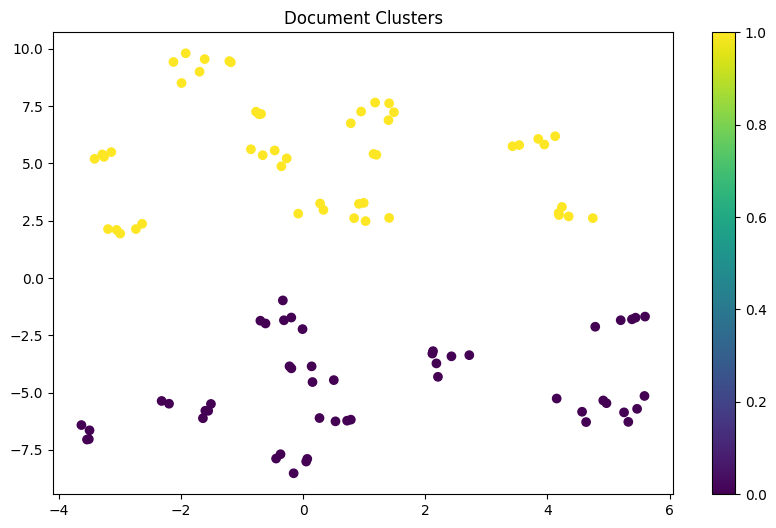

In [4]:
embeddings = get_embeddings(documents)

# Perform K-means clustering
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Visualize the clusters using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis')
plt.title('Document Clusters')
plt.colorbar(scatter)
plt.show()